<p align="center">
  <span style="color:Navy; font-size:200%; font-weight:bold; vertical-align:middle;">
    Temas Selectos: Python para Ciencias de la Tierra
  </span>
  <img src="attachment:LOGO_ENCIT.png" alt="ENCiT" width="160" style="vertical-align:middle; margin-left:20px;"/>
</p>
<p align="center" style="line-height:1.2;">
  <span style="color:RoyalBlue; font-size:160%;">Tema 3: Análisis espacial</span><br/>
  <span style="color:DodgerBlue; font-size:140%;">Notebook 1: Geopandas </span><br/>
  <span style="font-size:100%;color:forestgreen"> Escuela Nacional de Ciencias de la Tierra  |  Semestre 2026-I</span>
</p>

---

### ¿Por qué usar GeoPandas en Ciencias de la Tierra?

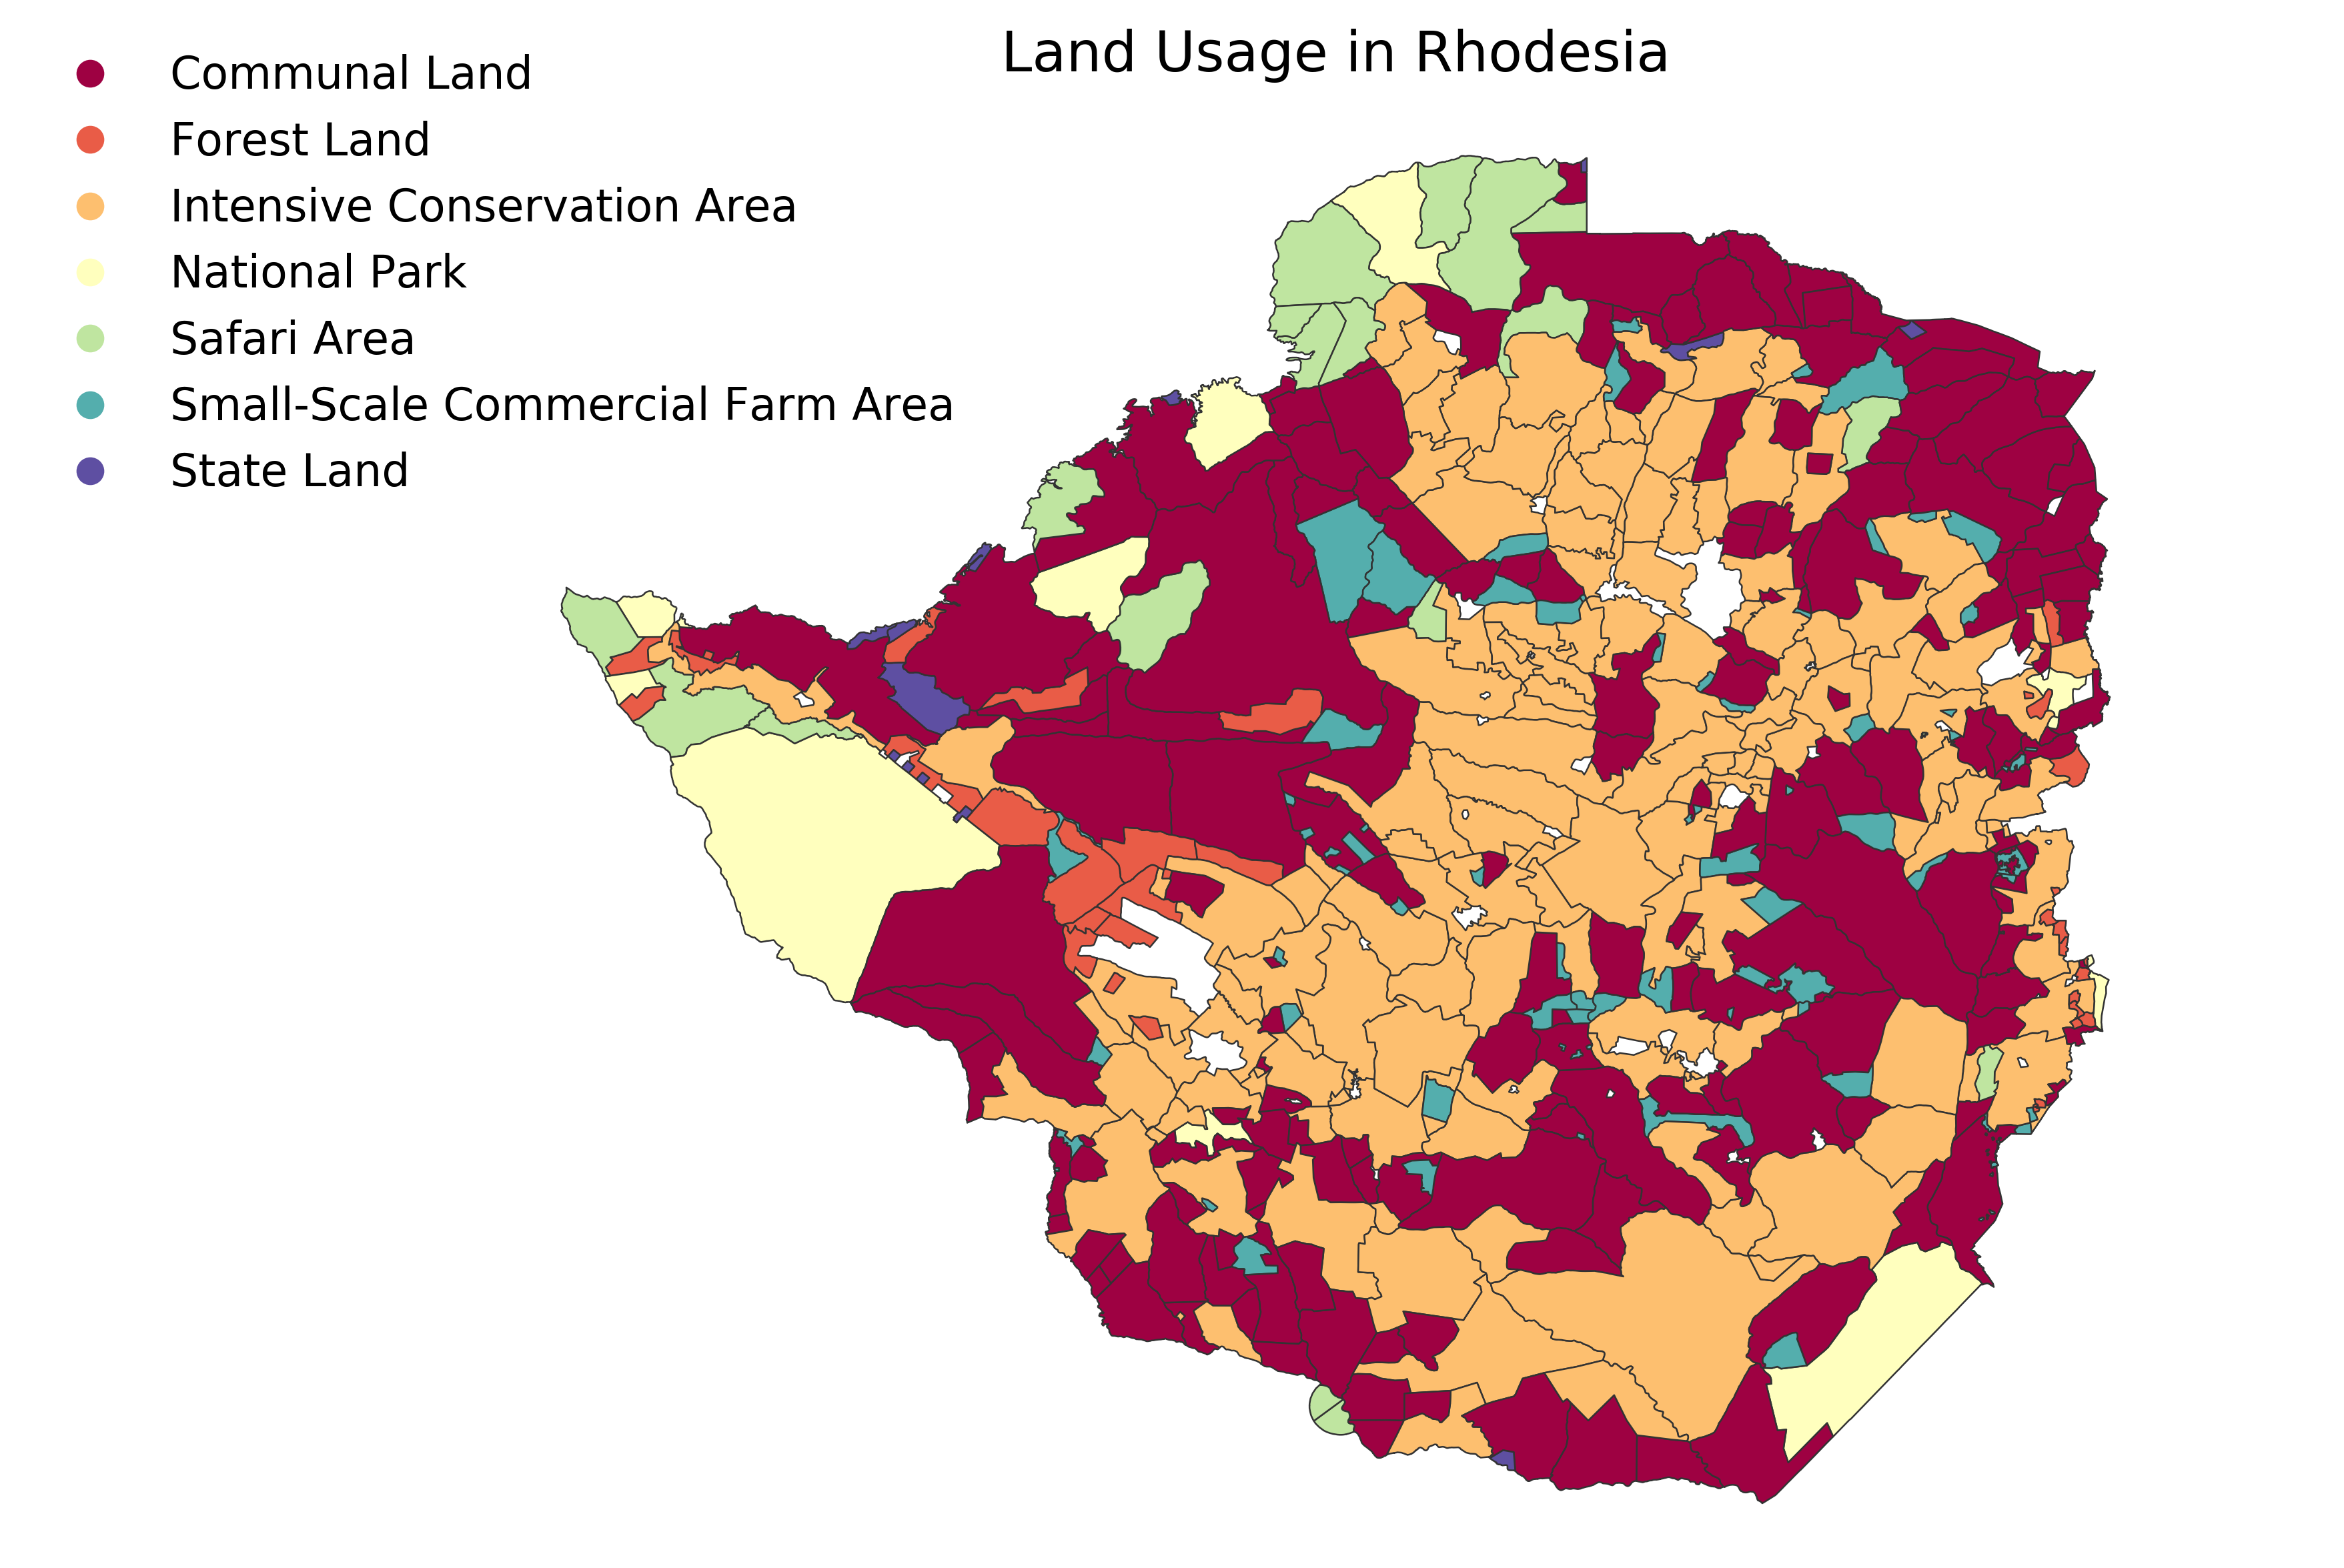

GeoPandas extiende pandas para trabajar con **datos espaciales vectoriales** (puntos, líneas y polígonos) en un mismo DataFrame que conoce su **sistema de referencia de coordenadas (CRS)**. Esto nos permite analizar y mapear fenómenos ambientales y geofísicos con un flujo de trabajo claro y reproducible.

Beneficios clave:
- Une *atributos tabulares* (como en pandas) con *geometrías* y *CRS* en una sola estructura (GeoDataFrame).
- Soporta operaciones espaciales comunes: *join espacial* (¿en qué polígono cae un punto?)
- Calcula *áreas y longitudes* correctamente al reproyectar a un CRS adecuado (p. ej., igual-área).
- Lee y escribe formatos estándar: *Shapefile*, *GeoJSON*, *GeoPackage*, entre otros.
- Se integra con *NumPy/pandas* para estadísticas y con *Matplotlib* para mapas rápidos (coropletas, capas superpuestas).
- Favorece la **reproducibilidad**: mismo código + mismos datos ⇒ mismo resultado/cartografía.

Ejemplos típicos en el curso:
- Asignar **estaciones** a **municipios/cuencas** (join espacial) y resumir promedios por polígono.
- Construir **zonas de influencia** (buffers) alrededor de pozos, sensores o fuentes de emisión.
- **Recortar** capas a un área de estudio y **disolver** límites por categoría (e.g., continente, ecorregión).
- Elaborar **mapas temáticos** con leyendas claras y escalas consistentes.


In [32]:
import geopandas as gpd
import geodatasets as gd
import pandas as pd
import matplotlib.pyplot as plt

### ¿Qué es *geodatasets*?

`geodatasets` es un paquete en Python que provee acceso rápido a **conjuntos de datos geoespaciales de ejemplo**.  
Fue creado para complementar librerías como **GeoPandas**, ofreciendo datos ya listos para usar en prácticas, demos y clases.

---

### ¿Por qué usarlo?

- Permite **cargar datos reales** de manera sencilla sin tener que buscarlos ni descargarlos manualmente.  
- Incluye datos comunes en análisis geográficos: límites de países, ciudades, placas tectónicas, cuencas hidrográficas, etc.  
- Es ideal para **ejercicios de aprendizaje**, ya que los archivos son livianos y estandarizados.  

---

### Ejemplo de uso básico

```python
import geopandas as gpd
import geodatasets

# Listar datasets disponibles
geodatasets.available()

# Cargar límites mundiales de Natural Earth
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))


In [33]:
# Ejemplos reales incluidos:
world  = gpd.read_file(gd.get_path("nybb"))  # por ejemplo, NY Boroughs (polígonos)
# También hay otros (ver docs de geodatasets). 

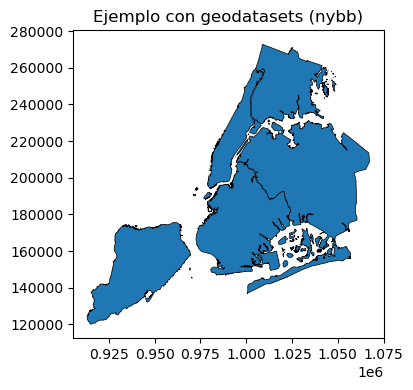

In [34]:
ax = world.plot(edgecolor="black", linewidth=0.5, figsize=(6,4))
ax.set_title("Ejemplo con geodatasets (nybb)")
plt.tight_layout()

### Descarga y uso de datos espaciales desde Natural Earth

En lugar de usar archivos locales, también podemos leer **archivos vectoriales directamente desde una URL**.  
Natural Earth provee conjuntos de datos de uso libre en distintos niveles de detalle (1:110m, 1:50m, 1:10m).

---

#### 1. Cargar países y ciudades
```python
url_world  = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
url_cities = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_populated_places_simple.zip"

world  = gpd.read_file(url_world)
cities = gpd.read_file(url_cities)


In [35]:
url_world  = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
url_cities = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_populated_places_simple.zip"

world  = gpd.read_file(url_world)
cities = gpd.read_file(url_cities)

Seleccionamos solo el polígono de México usando la columna "ADMIN".

Convertimos su proyección a EPSG:4326 (latitud/longitud en grados), para asegurar compatibilidad.

EPSG Geodetic Parameter Dataset.

Luego ajustamos las ciudades al mismo sistema de referencia espacial que México `to_crs`

Esto es esencial: todas las capas deben tener el mismo CRS para poder hacer operaciones espaciales.

In [36]:
# Filtrar México
mex = world[world["ADMIN"] == "Mexico"].to_crs("EPSG:4326")

# Asegurar mismo CRS y hacer join espacial (puntos dentro del polígono)
cities = cities.to_crs(mex.crs)

`sjoin` compara dos GeoDataFrames según su geometría.

Con predicate="within" seleccionamos únicamente las ciudades dentro de la geometría de México.

El resultado cities_mx es un subconjunto de ciudades filtradas por ubicación.

In [37]:
cities_mx = gpd.sjoin(cities, mex[["ADMIN","geometry"]], how="inner", predicate="within")

Ciudades encontradas en México: 2


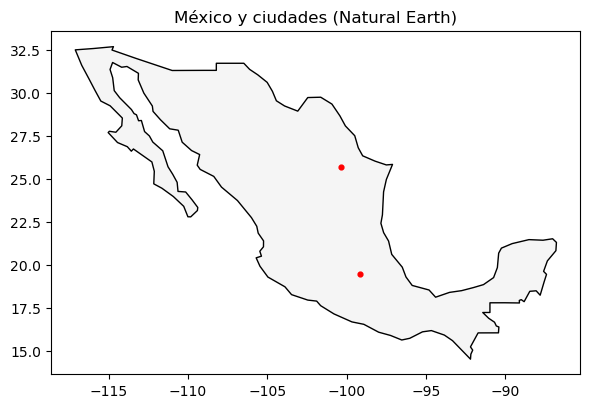

In [38]:
# Mapa rápido
ax = mex.plot(figsize=(6,6), color="whitesmoke", edgecolor="black")
cities_mx.plot(ax=ax, markersize=12, color="red")
ax.set_title("México y ciudades (Natural Earth)")
plt.tight_layout()
print("Ciudades encontradas en México:", len(cities_mx))

### 2) Medir áreas correctamente
Para áreas y distancias se recomienda un **CRS proyectado** (en metros).  
Usaremos un CRS global de **igual área** para calcular el área de México (km²).

In [39]:
# Proyectar a igual-área global y calcular área
mex_eq = mex.to_crs("EPSG:6933")
area_km2 = float(mex_eq.area.sum() / 1e6)
print("Área de México (km²):", round(area_km2, 0))

Área de México (km²): 1969359.0


### 3) Buffers de 100 km alrededor de algunas ciudades
Creamos zonas de influencia de **100 km**. Para buffers se usa un CRS en **metros** (por ejemplo **EPSG:3857**).  
Luego recortamos los buffers al límite de México y los dibujamos.


In [40]:
# Elegir algunas ciudades (por simplicidad, las primeras 6)
sample = cities_mx
print(sample)

     scalerank  natscale  labelrank       featurecla         name namepar  \
196          1       300          2  Admin-1 capital    Monterrey    None   
224          0       600          2  Admin-0 capital  Mexico City    None   

         namealt    nameascii  adm0cap  capalt  ... pop_other  rank_max  \
196         None    Monterrey        0       0  ...   3225636        12   
224  Ciudad de M  Mexico City        1       0  ...  10018444        14   

     rank_min          meganame      ls_name min_zoom       ne_id  \
196        12         Monterrey    Monterrey      3.7  1159151527   
224        14  Ciudad de Mdxico  Mexico City      2.1  1159151587   

                   geometry index_right   ADMIN  
196  POINT (-100.33 25.672)          27  Mexico  
224  POINT (-99.133 19.444)          27  Mexico  

[2 rows x 34 columns]


### Buffers y recortes espaciales

En análisis geoespacial a menudo nos interesa trabajar con **áreas de influencia** o "zonas cercanas" a un conjunto de puntos.  
Para eso se utiliza el método `.buffer()`, que genera un polígono alrededor de cada geometría a una distancia fija.  

---

#### 1. Crear un buffer
```python
buf = sample_3857.buffer(100_000)


In [41]:
# Trabajar en metros para el buffer
mex_3857    = mex.to_crs(3857)
sample_3857 = sample.to_crs(3857)

In [42]:
# Buffer de 100 km y recorte al polígono de México
buf = sample_3857.buffer(100_000)

`overlay` hace operaciones entre capas geoespaciales.

Con `how="intersection"` obtenemos únicamente la parte del buffer que cae dentro de México.

Esto evita que los buffers se extiendan fuera del polígono del país.

In [43]:
buf_gdf = gpd.GeoDataFrame(geometry=buf, crs=sample_3857.crs)
buf_clip = gpd.overlay(buf_gdf, mex_3857, how="intersection")

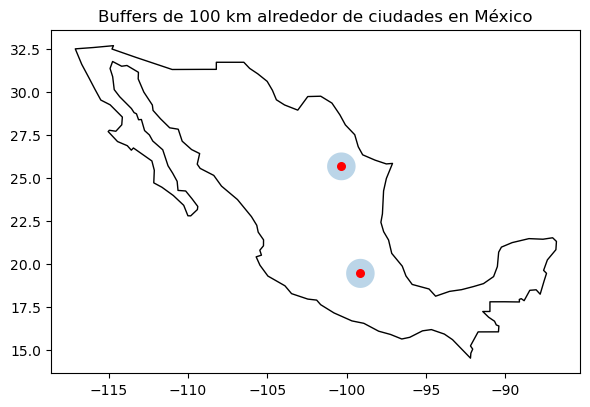

In [44]:
# Volver a geográficas para graficar junto con el país
buf_geo    = buf_clip.to_crs(mex.crs)
sample_geo = sample_3857.to_crs(mex.crs)
# Mapa final
ax = mex.plot(figsize=(6,6), color="white", edgecolor="black")
buf_geo.plot(ax=ax, alpha=0.3)
sample_geo.plot(ax=ax, color="red", markersize=30)
ax.set_title("Buffers de 100 km alrededor de ciudades en México")
plt.tight_layout()


### 4) Qué observar
- El **join espacial** asigna correctamente las ciudades a México.  
- Con un CRS proyectado, los **buffers** quedan en kilómetros reales.  
- El **área** cambia si mides en geográficas; usa igual-área para reportes.

 ## **<font color="DodgerBlue"> Ejemplo geocientífico: Sismos recientes y su relación con límites de placas </font>**

Objetivo (≈25–35 min):
- Cargar **sismos reales** (USGS) y **límites de placas**.
- Calcular **distancia al límite de placa más cercano**.
- Mapear y hacer un recuento por país.

Qué verás:
- Lectura directa desde URLs.
- `GeoDataFrame`, CRS, `sjoin_nearest` y choropleth sencillo.

### Datos sísmicos del USGS en formato GeoJSON

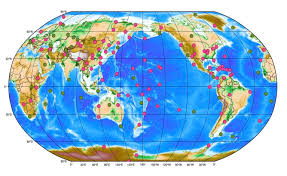

El **United States Geological Survey (USGS)** publica en tiempo real catálogos de sismos globales en distintos formatos.  
Uno de los más prácticos es **GeoJSON**, que combina datos tabulares con información geoespacial (latitud/longitud como geometrías).

---

In [45]:
# Sismos M>=4.5 del último mes (GeoJSON)
url_eq = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_month.geojson"
eq = gpd.read_file(url_eq)

### Límites de placas tectónicas (PB2002)

Además de fronteras políticas y ciudades, también podemos trabajar con **datos geológicos globales**.  
Un ejemplo clásico es el conjunto **PB2002** de Bird (2003), que contiene los principales **límites de placas tectónicas**.

---

Este archivo proviene de un repositorio de GitHub que recopila los límites de placas en formato GeoJSON.

Incluye segmentos de bordes de placas como líneas (LineString).

Cada segmento está etiquetado por tipo de límite:

Divergente (expansión, dorsales oceánicas).

Convergente (subducción, colisiones).

Transformante (fallas como San Andrés).

In [46]:
# Límites de placas (líneas, GeoJSON)
url_plates = "https://raw.githubusercontent.com/fraxen/tectonicplates/master/GeoJSON/PB2002_boundaries.json"
plates = gpd.read_file(url_plates)

In [47]:
# Campos útiles
eq["time"] = pd.to_datetime(eq["time"], unit="ms", errors="coerce")
eq = eq.to_crs("EPSG:4326")
plates = plates.to_crs(eq.crs)

print("Sismos cargados:", len(eq))
print("Límites de placa:", len(plates))

Sismos cargados: 633
Límites de placa: 241


In [48]:
# 2) Distancia al límite más cercano (en km)
eq_m     = eq.to_crs(3857)
plates_m = plates.to_crs(3857)

### Distancia de los sismos a los límites de placas

Una aplicación típica en geociencias es calcular qué tan cerca está un sismo de un límite tectónico.  
Con `GeoPandas` podemos hacerlo con un *spatial join*.

---

#### 1. Unión espacial por cercanía
```python
near = gpd.sjoin_nearest(
    eq_m[["geometry"]],
    plates_m[["geometry"]],
    how="left",
    distance_col="dist_m"
)


In [49]:
near = gpd.sjoin_nearest(
    eq_m[["geometry"]],
    plates_m[["geometry"]],
    how="left",
    distance_col="dist_m"
)

# Colapsa empates: una distancia (mínima) por índice de sismo
dist_km = (near["dist_m"]
           .groupby(near.index)   # índice del GeoDataFrame izquierdo (eq_m)
           .min()
           .rename("dist_km") / 1000.0)

# Alinea por índice y agrega a eq
eq = eq.join(dist_km)
eq["near_plate"] = eq["dist_km"] <= 100.0


`sjoin_nearest` busca, para cada sismo (`eq_m`), el segmento de límite más cercano en plates_m.

Guarda la distancia en una nueva columna dist_m (en metros, porque usamos CRS proyectado EPSG:3857).

Puede haber empates si un sismo está equidistante a dos segmentos.

Para cada sismo, tomamos la distancia mínima. `min`

Convertimos de metros a kilómetros.

### Mapa rápido

Pintamos los sismos: círculos más oscuros si están cerca de un límite de placa.

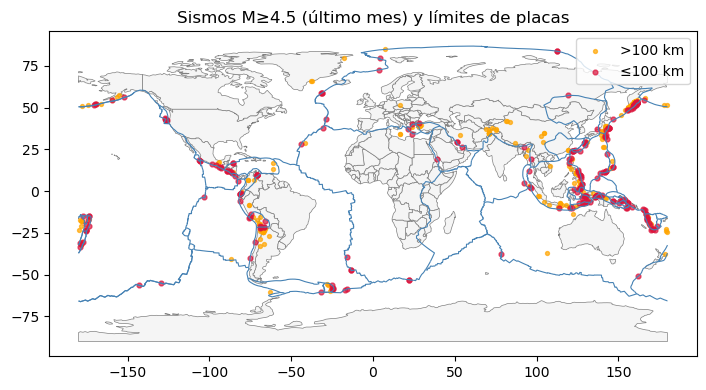

In [50]:
fig, ax = plt.subplots(figsize=(8,4))
world.plot(ax=ax, color="whitesmoke", edgecolor="gray", linewidth=0.5)
plates.plot(ax=ax, color="steelblue", linewidth=0.8)
# dividmos en dos grupos, cercanos y lejanos a los 100 km
eq_close = eq[eq["near_plate"]]
eq_far   = eq[~eq["near_plate"]]

eq_far.plot(ax=ax, markersize=8, color="orange", alpha=0.7, label=">100 km")
eq_close.plot(ax=ax, markersize=12, color="crimson", alpha=0.7, label="≤100 km")

ax.set_title("Sismos M≥4.5 (último mes) y límites de placas")
ax.legend()
plt.tight_layout()

### Sismos por país con *spatial join*

Una vez que tenemos los sismos en un `GeoDataFrame`, podemos preguntarnos:  
👉 ¿En qué país cayó cada evento?

---

`sjoin` combina dos capas: sismos (puntos) y países (polígonos).

Con `predicate="within"` buscamos qué punto está dentro de qué polígono.

El resultado añade la columna `"ADMIN"` (nombre del país) a cada sismo.

`how="left"` asegura que mantenemos todos los sismos, aunque alguno quede fuera de los polígonos.

In [51]:
# 3) Join espacial sismos→países
eq_countries = gpd.sjoin(
    eq[["geometry","mag","place","time"]].to_crs(world.crs),
    world[["ADMIN","geometry"]],
    how="left",
    predicate="within"
)
# contamos por cada pais el numero de sismos
counts = eq_countries.groupby("ADMIN", dropna=True).size().rename("n_eq").reset_index()
# unir con el mapa mundial
world_eq = world.merge(counts, on="ADMIN", how="left").fillna({"n_eq":0})

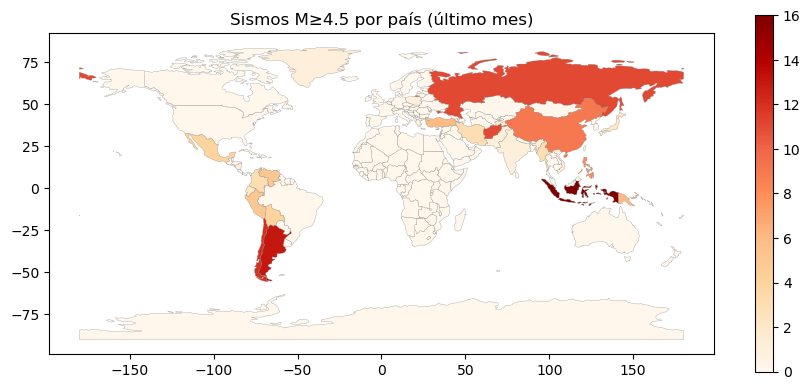

               ADMIN  n_eq
10         Indonesia    16
1          Argentina    13
3              Chile    12
0        Afghanistan    11
21            Russia    11
4              China     9
19       Philippines     8
23            Turkey     6
17  Papua New Guinea     6
24         Venezuela     5


In [52]:
# Mapa coroplético
fig, ax = plt.subplots(figsize=(9,4))
world_eq.plot(column="n_eq", ax=ax, legend=True, cmap="OrRd",
              edgecolor="gray", linewidth=0.2, missing_kwds={"color":"lightgray"})
ax.set_title("Sismos M≥4.5 por país (último mes)")
plt.tight_layout(); plt.show()

# Vista rápida de top-10
top10 = counts.sort_values("n_eq", ascending=False).head(10)
print(top10)


### Guía: Lagos por país con GeoPandas (Natural Earth)

Objetivo: cargar volcanes y países, asignar cada volcán a un país con un join espacial, contar volcanes por país y mapear el resultado.

---

#### Paso 1. Carga los datos de lagos (puntos)
- Lee el dataset de Natural Earth (10m):  
  `https://naciscdn.org/naturalearth/10m/physical/ne_10m_lakes.zip`
- Guarda el resultado en un GeoDataFrame llamado `lakes`.

Sugerencia: revisa columnas disponibles y el `crs` con `lakes.head()` y `lakes.crs`.

---



#### Paso 2.  Reproyecta a un CRS igual-área global (p. ej., EPSG:6933) para que las áreas salgan en m² coherentes.

Sugerencia: confirma que existe la columna `ADMIN` (nombre oficial del país).

---

### Paso 3 — Intersección espacial

Usa `gpd.overlay(lagos, países, how="intersection")` para recortar cada polígono de lago al país donde cae (si cruza fronteras, se parte).


### Paso 4 — Área y agregación

Calcula area_km2 = geometry.area / 1e6 en la capa intersectada.

Agrupa por ADMIN (nombre del país) y suma area_km2 → obtén una tabla area_lagos_por_pais.

### Paso 5 — Unir y mapear

Haz un merge de la tabla de áreas al GeoDataFrame de países.

Mapa coroplético con column="area_lagos_km2", paleta legible (p. ej., "Blues"), leyenda y bordes sutiles.

(Opcional) Superpone los contornos de lagos para referencia.

### Paso 6 — Preguntas rápidas y adicionales

¿Qué países concentran más área de lagos? Muestra el top 10.

¿Cómo cambian los resultados si usas un CRS que no es igual-área?

Filtra solo América y repite; compara con el mundo.